In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def is_near_edge(box, image_width, image_height, margin):
    x1, y1, x2, y2 = box[:4]
    return x1 < margin or y1 < margin or x2 > image_width - margin or y2 > image_height - margin

def soft_nms(detections, sigma=0.35, Nt=0.6,threshold=0.2, method=2, image_width=any, image_height=any, margin=5):
    """
    Soft-NMS implementation with edge filtering.
    """
    D = detections.copy()
    N = D.shape[0]
    filtered_boxes = []

    # Filter out boxes near the edges
    for i in range(N):
        if not is_near_edge(D[i], image_width, image_height, margin):
            filtered_boxes.append(D[i])

    D = np.array(filtered_boxes)
    N = D.shape[0]

    for i in range(N):
        maxpos = i

        # Get max box
        maxscore = D[i, 4]
        for j in range(i + 1, N):
            if D[j, 4] > maxscore:
                maxscore = D[j, 4]
                maxpos = j

        # Swap
        D[i, :], D[maxpos, :] = D[maxpos, :].copy(), D[i, :].copy()

        # IoU calculation
        xx1 = np.maximum(D[i, 0], D[i + 1:, 0])
        yy1 = np.maximum(D[i, 1], D[i + 1:, 1])
        xx2 = np.minimum(D[i, 2], D[i + 1:, 2])
        yy2 = np.minimum(D[i, 3], D[i + 1:, 3])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h


        areas = (D[i + 1:, 2] - D[i + 1:, 0] + 1) * (D[i + 1:, 3] - D[i + 1:, 1] + 1)
        ovr = inter / (areas + (D[i, 2] - D[i, 0] + 1) * (D[i, 3] - D[i, 1] + 1) - inter)


        # Apply Soft-NMS
        if method == 1:  # linear
            weight = np.ones_like(ovr)
            weight[ovr > Nt] = weight[ovr > Nt] - ovr[ovr > Nt]
        elif method == 2:  # gaussian

            weight = np.exp(-(ovr * ovr) / sigma)


        else:  # original NMS
            weight = np.ones_like(ovr)
            weight[ovr > Nt] = 0



        D[i + 1:, 4] = D[i + 1:, 4] * weight


    keep = D[:, 4] > threshold



    return D[keep]


76.0 57.0 133.0 109.0
70.0 50.0 120.0 105.0


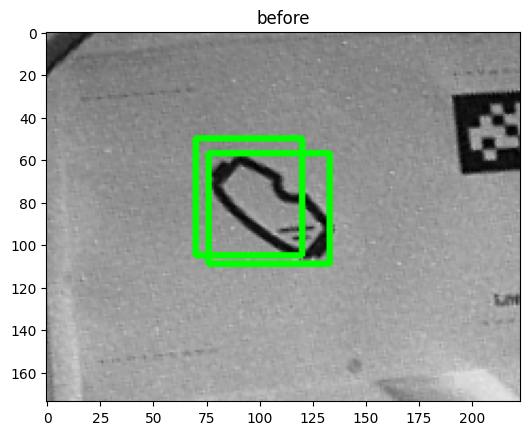

76.0 57.0 133.0 109.0


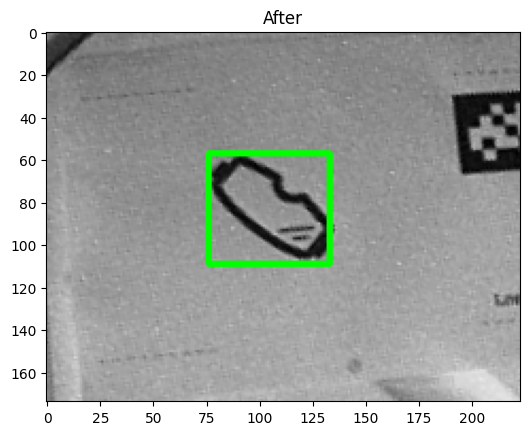

In [5]:
detections = np.array([
    [76.0, 57.0, 133.0, 109.0, 0.9994686], #[x1,y1,x2,y2,score]
    [70.0, 50.0, 120.0, 105.0, 0.35]
])
image_path = '/explain_class/colab_playground/assets/image.png'
image = cv2.imread(image_path)

# Get image dimensions
image_height, image_width = image.shape[:2]
result = soft_nms(detections, sigma=0.34, Nt=0.6, method=2, image_width=image_width, image_height=image_height, margin=5)
show_img = image.copy()
show_img1 = image.copy()

# Iterate over the indices of result using range()
for i in range(len(detections)):
  # Iterate over the indices of the inner array (excluding the last element)
    x1, y1, x2, y2 = detections[i][0:4]

    # Draw the rectangle
    cv2.rectangle(show_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    # Display the image

    print(x1, y1, x2, y2)

plt.title("before")
plt.imshow(show_img)
plt.show()
for i in range(len(result)):
  # Iterate over the indices of the inner array (excluding the last element)
    x1, y1, x2, y2 = result[i][0:4]

    # Draw the rectangle
    cv2.rectangle(show_img1, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    # Display the image

    print(x1, y1, x2, y2)

plt.title("After")
plt.imshow(show_img1)
plt.show()